In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/MAXI_J1848m015/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J1848m015/'


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/hendrics/io.py:24: UserWarning: Warning! NetCDF is not available. Using pickle format.
  warnings.warn(msg)


Working on Macbook


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/pulse/accelsearch.py:24: UserWarning: Using standard numpy fft
  warnings.warn("Using standard numpy fft")


# Soft State

In [2]:
OBSID='90601340002'

products_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'
chu_combos = ['12','23','2','3']

In [3]:
PI_min = eV_to_PI(3000)     # 3.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

plt.ion()
bin_time = 1/1024
buff = False
bkg_bin = 32

plt.figure(figsize=(9,6))
lcurve_ax = plt.gca()

total_cpds_list = []
total_pds_list = []
for split_time in [128,256,512,1024]:
    print('split time: ' + str(split_time))
    cospectra = []
    powerspectra = []
    for chu in chu_combos:
        print('chu' + chu)

        srcA_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'A06_chu' + chu + '_S_sr.lc')
        bkgA_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'A06_chu' + chu + '_S_bk.lc')
        srcB_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'B06_chu' + chu + '_S_sr.lc')
        bkgB_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'B06_chu' + chu + '_S_bk.lc')

        area_ratio = np.square(srcA_lc.radius/bkgA_lc.radius)

        bkg_rate = sum_lc(bkgA_lc, bkgB_lc).meanrate
        src_rate = sum_lc(srcA_lc, srcB_lc).meanrate - (area_ratio * bkg_rate)

        events = extract_events(products_dir + 'nu' + OBSID + 'A06_chu' + chu + '_S_cl_bc.evt', \
                    products_dir + 'nu' + OBSID + 'B06_chu' + chu + '_S_cl_bc.evt')


        events[0].centroid=srcA_lc.centroid
        events[0].radius=srcA_lc.radius
        events[1].centroid=srcB_lc.centroid
        events[1].radius=srcB_lc.radius

        total_curve = sum_lc(bkg_subtract(srcA_lc, bkgA_lc, bkg_bin=bkg_bin), bkg_subtract(srcB_lc, bkgB_lc, bkg_bin=bkg_bin))
        start_time = np.min(total_curve.time) - total_curve.dt/2
        
        if split_time==128:
            lcurve_ax.errorbar(total_curve.time-start_time, total_curve.countrate, xerr=total_curve.dt/2, yerr=total_curve.countrate_err, ls='', lw=1.0, label = 'CHU'+chu)
            ls_freq, ls_power = LombScargle(total_curve.time-start_time, total_curve.countrate, dy=total_curve.countrate_err).autopower()
            plt.figure(figsize=(9,6))
            plt.errorbar(ls_freq, ls_power, lw=0.5)
            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Lomb-Scargle Power')
            plt.tight_layout()
            # plt.show()
            plt.savefig(plot_dir + OBSID + '_LombScargle_' + 'CHU' + chu + '.pdf')
            plt.close()




        curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = srcA_lc.centroid, radius = srcA_lc.radius)
        curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = srcB_lc.centroid, radius = srcB_lc.radius)
        curve_bkgA = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = bkgA_lc.centroid, radius = bkgA_lc.radius)
        curve_bkgB = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = bkgB_lc.centroid, radius = bkgB_lc.radius)
        area_ratioA = np.square(srcA_lc.radius/bkgA_lc.radius)
        area_ratioB = np.square(srcB_lc.radius/bkgB_lc.radius)
        geomean_totrate = np.sqrt(curve_A.meanrate * curve_B.meanrate)
        geomean_srcrate = np.sqrt((curve_A.meanrate-(area_ratioA*curve_bkgA.meanrate)) * (curve_B.meanrate-(area_ratioB*curve_bkgB.meanrate)))

        print(np.min(curve_A.gti.T[1]-curve_A.gti.T[0]))
        print(np.max(curve_A.gti.T[1]-curve_A.gti.T[0]))
        print(np.sum(curve_A.gti.T[1]-curve_A.gti.T[0]))

        if np.max(curve_A.gti.T[1]-curve_A.gti.T[0]) >= split_time:
            ### Calculate CPDS
            averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
            averaged_cross.power = averaged_cross.power * np.square((1/(1-0.0025*(geomean_totrate))) * (geomean_totrate/geomean_srcrate))
            averaged_cross.power_err = averaged_cross.power_err * np.square((1/(1-0.0025*(geomean_totrate))) * (geomean_totrate/geomean_srcrate))

            cospectra.append(averaged_cross)

#             summed_curve = sum_lc(curve_A, curve_B)
#             averaged_pds = powspec.AveragedPowerspectrum(summed_curve, segment_size=split_time, norm = 'leahy')
#             averaged_pds.power = (averaged_pds.power - 2.0) * np.square(1/(1-0.0025*(geomean_totrate))) * \
#                                     (summed_curve.meanrate/np.square(summed_curve.meanrate - (area_ratioA*curve_bkgA.meanrate) - (area_ratioB*curve_bkgB.meanrate)))
#             averaged_pds.power_err = averaged_pds.power_err * np.square(1/(1-0.0025*(geomean_totrate))) * \
#                                     (summed_curve.meanrate/np.square(summed_curve.meanrate - (area_ratioA*curve_bkgA.meanrate) - (area_ratioB*curve_bkgB.meanrate)))

#             powerspectra.append(averaged_pds)

    total_cpds = copy.deepcopy(cospectra[0])
    if len(cospectra) > 1:
        total_m = np.sum(np.array([cpds.m for cpds in cospectra]))
        total_power = np.sum([(cpds.power * cpds.m) for cpds in cospectra], axis=0)/total_m
        total_err = np.sqrt(np.sum([np.square(cpds.power_err * cpds.m) for cpds in cospectra], axis=0))/total_m

        total_cpds.m = total_m
        total_cpds.power = total_power
        total_cpds.power_err = total_err
    total_cpds_list.append(total_cpds)

#     total_pds = copy.deepcopy(powerspectra[0])
#     if len(powerspectra) > 1:
#         total_m = np.sum(np.array([pds.m for pds in powerspectra]))
#         total_power = np.sum([(pds.power * pds.m) for pds in powerspectra], axis=0)/total_m
#         total_err = np.sqrt(np.sum([np.square(pds.power_err * pds.m) for pds in powerspectra], axis=0))/total_m

#         total_pds.m = total_m
#         total_pds.power = total_power
#         total_pds.power_err = total_err
#     total_pds_list.append(total_pds)


    ### Plot CPDS
    f_res = 0.5
    total_cpds_log = total_cpds.rebin_log(f=f_res)
    total_cpds_log_err = total_cpds.df*np.power(1.+f_res, range(len(total_cpds_log.freq)))/2.

    plt.figure(figsize=(9,6))
    plt.errorbar(total_cpds_log.freq, total_cpds_log.power*total_cpds_log.freq, xerr=total_cpds_log_err, yerr=total_cpds_log.power_err*total_cpds_log.freq, fmt='none', color='black', lw=0.5)
    plt.step(np.concatenate([total_cpds_log.freq-total_cpds_log_err, [total_cpds_log.freq[-1]+total_cpds_log_err[-1]]]), \
             np.concatenate([total_cpds_log.power*total_cpds_log.freq, [(total_cpds_log.power*total_cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
    plt.xscale('log')
    plt.ylim((1e-6,np.max(total_cpds_log.power*total_cpds_log.freq) * 3))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_nuPnu_' + str(int(split_time)) + 's_chusplit.pdf')
    plt.close()

    plt.figure(figsize=(9,6))
    plt.errorbar(total_cpds_log.freq, total_cpds_log.power, xerr=total_cpds_log_err, yerr=total_cpds_log.power_err, fmt='none', color='black', lw=0.5)
    plt.step(np.concatenate([total_cpds_log.freq-total_cpds_log_err, [total_cpds_log.freq[-1]+total_cpds_log_err[-1]]]), \
             np.concatenate([total_cpds_log.power, [total_cpds_log.power[-1]]]), where='post', color='black', lw=0.5)
    plt.xscale('log')
    plt.ylim((1e-6, np.max(total_cpds_log.power) * 3))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_chusplit.pdf')
    plt.close()

    plt.figure(figsize=(9,6), dpi=100)
    plt.errorbar(total_cpds.freq, total_cpds.power, xerr=total_cpds.df/2, yerr=total_cpds.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
    plt.step(np.concatenate([total_cpds.freq-total_cpds.df/2, [total_cpds.freq[-1]+total_cpds.df/2]]), \
             np.concatenate([total_cpds.power, [total_cpds.power[-1]]]), where='post', color='black', lw=0.5, rasterized=True)
    plt.ylim((1e-4, np.max(total_cpds.power) * 3))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_chusplit_unbinned.pdf')
    plt.close()

#     ### Plot PDS
#     f_res = 0.5
#     total_pds_log = total_pds.rebin_log(f=f_res)
#     total_pds_log_err = total_pds.df*np.power(1.+f_res, range(len(total_pds_log.freq)))/2.

#     plt.figure(figsize=(9,6))
#     plt.errorbar(total_pds_log.freq, total_pds_log.power*total_pds_log.freq, xerr=total_pds_log_err, yerr=total_pds_log.power_err*total_pds_log.freq, fmt='none', color='black', lw=0.5)
#     plt.step(np.concatenate([total_pds_log.freq-total_pds_log_err, [total_pds_log.freq[-1]+total_pds_log_err[-1]]]), \
#              np.concatenate([total_pds_log.power*total_pds_log.freq, [(total_pds_log.power*total_pds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
#     plt.xscale('log')
#     plt.ylim((1e-6,np.max(total_pds_log.power*total_pds_log.freq) * 3))
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_nuPnu_' + str(int(split_time)) + 's_chusplit.pdf')
#     plt.close()

#     plt.figure(figsize=(9,6))
#     plt.errorbar(total_pds_log.freq, total_pds_log.power, xerr=total_pds_log_err, yerr=total_pds_log.power_err, fmt='none', color='black', lw=0.5)
#     plt.step(np.concatenate([total_pds_log.freq-total_pds_log_err, [total_pds_log.freq[-1]+total_pds_log_err[-1]]]), \
#              np.concatenate([total_pds_log.power, [total_pds_log.power[-1]]]), where='post', color='black', lw=0.5)
#     plt.xscale('log')
#     plt.ylim((1e-6, np.max(total_pds_log.power) * 3))
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_Pnu_' + str(int(split_time)) + 's_chusplit.pdf')
#     plt.close()

#     plt.figure(figsize=(9,6), dpi=100)
#     plt.errorbar(total_pds.freq, total_pds.power, xerr=total_pds.df/2, yerr=total_pds.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
#     plt.step(np.concatenate([total_pds.freq-total_pds.df/2, [total_pds.freq[-1]+total_pds.df/2]]), \
#              np.concatenate([total_pds.power, [total_pds.power[-1]]]), where='post', color='black', lw=0.5, rasterized=True)
#     plt.ylim((1e-4, np.max(total_cpds.power) * 3))
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_Pnu_' + str(int(split_time)) + 's_chusplit_unbinned.pdf')
#     plt.close()
    
lcurve_ax.set_xlabel('Time (s)')
lcurve_ax.set_ylabel(r'$NuSTAR\ \mathrm{count\ rate\ (3-78\,keV)}$')
lcurve_ax.legend()
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_lc_chusplit.pdf')
plt.close()

split time: 128
chu12
1753.6856764554977
1900.9332193136215
5545.552053928375


41it [00:02, 19.85it/s]
41it [00:01, 21.96it/s]
41it [00:02, 20.42it/s]


chu23
0.25000089406967163
199.99884885549545
999.991590321064


3it [00:00, 15.20it/s]
3it [00:00, 22.07it/s]
3it [00:00, 18.67it/s]


chu2
0.2499992847442627
50.999136447906494
200.4978188276291
chu3
0.25000321865081787
689.0039887428284
2902.7625836133957


18it [00:00, 21.17it/s]
18it [00:00, 21.91it/s]
18it [00:00, 21.93it/s]


split time: 256
chu12
1753.6856764554977
1900.9332193136215
5545.552053928375


20it [00:01, 10.01it/s]
20it [00:02,  9.40it/s]
20it [00:02,  9.33it/s]


chu23
0.25000089406967163
199.99884885549545
999.991590321064
chu2
0.2499992847442627
50.999136447906494
200.4978188276291
chu3
0.25000321865081787
689.0039887428284
2902.7625836133957


7it [00:00,  8.92it/s]
7it [00:00, 10.57it/s]
7it [00:00, 10.62it/s]


split time: 512
chu12
1753.6856764554977
1900.9332193136215
5545.552053928375


9it [00:02,  4.34it/s]
9it [00:02,  4.49it/s]
9it [00:01,  4.68it/s]


chu23
0.25000089406967163
199.99884885549545
999.991590321064
chu2
0.2499992847442627
50.999136447906494
200.4978188276291
chu3
0.25000321865081787
689.0039887428284
2902.7625836133957


1it [00:00,  3.40it/s]
1it [00:00,  4.23it/s]
1it [00:00,  4.26it/s]


split time: 1024
chu12
1753.6856764554977
1900.9332193136215
5545.552053928375


3it [00:01,  1.77it/s]
3it [00:01,  1.77it/s]
3it [00:01,  1.92it/s]


chu23
0.25000089406967163
199.99884885549545
999.991590321064
chu2
0.2499992847442627
50.999136447906494
200.4978188276291
chu3
0.25000321865081787
689.0039887428284
2902.7625836133957


In [5]:
total_cpds = total_cpds_list[-1]
split_time = [128.,256.,512.,1024.][-1]
popt, pcov, chisq0, chisq = model_continuum_noise_pl(total_cpds, plot=True, plot_dir=plot_dir, \
                                                              plot_name=OBSID + '_' + str(int(split_time)) + 's_chusplit_pl.pdf', f_res = f_res)
print(popt)
print(np.sqrt(np.diag(pcov)))
# print(np.sqrt(popt[1]/2))

rms = np.sqrt(popt[0]*((split_time*2) - (2*bin_time)))
rms_err=(np.sqrt(np.diag(pcov))[0]/popt[0])*(rms/2.)

print(str(rms) + ' +/- ' + str(2.57583*rms_err))

[2.13834208e-06]
[1.12535924e-07]
0.06617643395346964 +/- 0.0044854349150315045


# Hard State

In [2]:
OBSID='90601341002'
products_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'
chu_combos = ['123','13','12','23','2','3']

split time: 128
chu123
0.24998921155929565
349.75216805934906
2204.2634246349335


13it [00:00, 22.11it/s]
13it [00:00, 22.53it/s]
13it [00:00, 23.05it/s]


chu13
0.2499936819076538
220.31593191623688
2439.854994237423


11it [00:00, 18.50it/s]
11it [00:00, 21.46it/s]
11it [00:00, 20.39it/s]


chu12
0.24998873472213745
2007.959807395935
22564.017114937305


167it [00:07, 21.68it/s]
167it [00:08, 19.95it/s]
167it [00:07, 21.96it/s]


chu23
0.25000572204589844
350.00202238559723
850.2547100186348


4it [00:00, 19.48it/s]
4it [00:00, 19.56it/s]
4it [00:00, 21.07it/s]


chu2
0.2499874234199524
100.99987643957138
403.74931555986404
chu3
0.24999123811721802
900.5158141851425
8463.901200056076


60it [00:02, 21.55it/s]
60it [00:02, 22.15it/s]
60it [00:02, 22.99it/s]


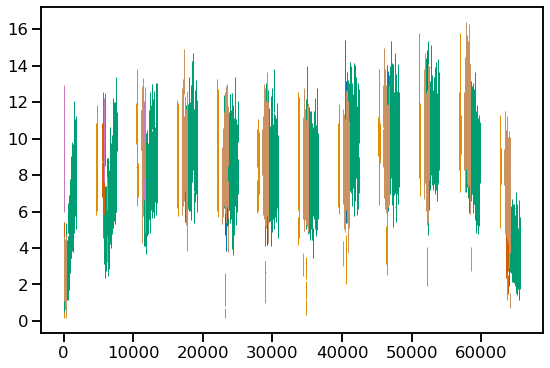

In [9]:
PI_min = eV_to_PI(3000)     # 3.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

plt.ion()
bin_time = 1/1024
buff = False
bkg_bin = 32

plt.figure(figsize=(9,6))
lcurve_ax = plt.gca()

total_cpds_list = []
total_pds_list = []

for split_time in [128]:
    print('split time: ' + str(split_time))
    cospectra = []
    powerspectra = []
    for chu in chu_combos:
        print('chu' + chu)

        srcA_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'A06_chu' + chu + '_S_sr.lc')
        bkgA_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'A06_chu' + chu + '_S_bk.lc')
        srcB_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'B06_chu' + chu + '_S_sr.lc')
        bkgB_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+'B06_chu' + chu + '_S_bk.lc')

        area_ratio = np.square(srcA_lc.radius/bkgA_lc.radius)

        bkg_rate = sum_lc(bkgA_lc, bkgB_lc).meanrate
        src_rate = sum_lc(srcA_lc, srcB_lc).meanrate - (area_ratio * bkg_rate)

        events = extract_events(products_dir + 'nu' + OBSID + 'A06_chu' + chu + '_S_cl_bc.evt', \
                    products_dir + 'nu' + OBSID + 'B06_chu' + chu + '_S_cl_bc.evt')


        events[0].centroid=srcA_lc.centroid
        events[0].radius=srcA_lc.radius
        events[1].centroid=srcB_lc.centroid
        events[1].radius=srcB_lc.radius

        total_curve = sum_lc(bkg_subtract(srcA_lc, bkgA_lc, bkg_bin=bkg_bin), bkg_subtract(srcB_lc, bkgB_lc, bkg_bin=bkg_bin))
        start_time = np.min(total_curve.time) - total_curve.dt/2
        
        if split_time==128:
            lcurve_ax.errorbar(total_curve.time-start_time, total_curve.countrate, xerr=total_curve.dt/2, yerr=total_curve.countrate_err, ls='', lw=1.0, label = 'CHU'+chu)
            lomb_scargle = LombScargle(total_curve.time-start_time, total_curve.countrate, dy=total_curve.countrate_err, normalization='psd')
            ls_freq, ls_power = lomb_scargle.autopower()
            plt.figure(figsize=(9,6))
            plt.errorbar(ls_freq, ls_power/np.var(total_curve.countrate), lw=0.5)
            plt.axhline(lomb_scargle.false_alarm_level(1-0.9545, method='bootstrap'), color='red')
            plt.axhline(lomb_scargle.false_alarm_level(1-0.9973, method='bootstrap'), color='green')
            plt.axhline(lomb_scargle.false_alarm_level(5.733e-7, method='bootstrap'), color='purple')
            plt.xscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Lomb-Scargle Power')
            plt.tight_layout()
            # plt.show()
            plt.savefig(plot_dir + OBSID + '_LombScargle_' + 'CHU' + chu + '.pdf')
            plt.close()

        curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = srcA_lc.centroid, radius = srcA_lc.radius)
        curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = srcB_lc.centroid, radius = srcB_lc.radius)
        curve_bkgA = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = bkgA_lc.centroid, radius = bkgA_lc.radius)
        curve_bkgB = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = bkgB_lc.centroid, radius = bkgB_lc.radius)
        area_ratioA = np.square(srcA_lc.radius/bkgA_lc.radius)
        area_ratioB = np.square(srcB_lc.radius/bkgB_lc.radius)
        geomean_totrate = np.sqrt(curve_A.meanrate * curve_B.meanrate)
        geomean_srcrate = np.sqrt((curve_A.meanrate-(area_ratioA*curve_bkgA.meanrate)) * (curve_B.meanrate-(area_ratioB*curve_bkgB.meanrate)))

        print(np.min(curve_A.gti.T[1]-curve_A.gti.T[0]))
        print(np.max(curve_A.gti.T[1]-curve_A.gti.T[0]))
        print(np.sum(curve_A.gti.T[1]-curve_A.gti.T[0]))

        if np.max(curve_A.gti.T[1]-curve_A.gti.T[0]) >= split_time:
            ### Calculate CPDS
            averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
            averaged_cross.power = averaged_cross.power * np.square((1/(1-0.0025*(geomean_totrate))) * (geomean_totrate/geomean_srcrate))
            averaged_cross.power_err = averaged_cross.power_err * np.square((1/(1-0.0025*(geomean_totrate))) * (geomean_totrate/geomean_srcrate))

            cospectra.append(averaged_cross)

#             summed_curve = sum_lc(curve_A, curve_B)
#             averaged_pds = powspec.AveragedPowerspectrum(summed_curve, segment_size=split_time, norm = 'leahy')
#             averaged_pds.power = (averaged_pds.power - 2.0) * np.square(1/(1-0.0025*(geomean_totrate))) * \
#                                     (summed_curve.meanrate/np.square(summed_curve.meanrate - (area_ratioA*curve_bkgA.meanrate) - (area_ratioB*curve_bkgB.meanrate)))
#             averaged_pds.power_err = averaged_pds.power_err * np.square(1/(1-0.0025*(geomean_totrate))) * \
#                                     (summed_curve.meanrate/np.square(summed_curve.meanrate - (area_ratioA*curve_bkgA.meanrate) - (area_ratioB*curve_bkgB.meanrate)))

#             powerspectra.append(averaged_pds)

    total_cpds = copy.deepcopy(cospectra[0])
    if len(cospectra) > 1:
        total_m = np.sum(np.array([cpds.m for cpds in cospectra]))
        total_power = np.sum([(cpds.power * cpds.m) for cpds in cospectra], axis=0)/total_m
        total_err = np.sqrt(np.sum([np.square(cpds.power_err * cpds.m) for cpds in cospectra], axis=0))/total_m

        total_cpds.m = total_m
        total_cpds.power = total_power
        total_cpds.power_err = total_err
    total_cpds_list.append(total_cpds)

#     total_pds = copy.deepcopy(powerspectra[0])
#     if len(powerspectra) > 1:
#         total_m = np.sum(np.array([pds.m for pds in powerspectra]))
#         total_power = np.sum([(pds.power * pds.m) for pds in powerspectra], axis=0)/total_m
#         total_err = np.sqrt(np.sum([np.square(pds.power_err * pds.m) for pds in powerspectra], axis=0))/total_m

#         total_pds.m = total_m
#         total_pds.power = total_power
#         total_pds.power_err = total_err
#     total_pds_list.append(total_pds)


    ### Plot CPDS
    f_res = 0.5
    total_cpds_log = total_cpds.rebin_log(f=f_res)
    total_cpds_log_err = total_cpds.df*np.power(1.+f_res, range(len(total_cpds_log.freq)))/2.

    plt.figure(figsize=(9,6))
    plt.errorbar(total_cpds_log.freq, total_cpds_log.power*total_cpds_log.freq, xerr=total_cpds_log_err, yerr=total_cpds_log.power_err*total_cpds_log.freq, fmt='none', color='black', lw=0.5)
    plt.step(np.concatenate([total_cpds_log.freq-total_cpds_log_err, [total_cpds_log.freq[-1]+total_cpds_log_err[-1]]]), \
             np.concatenate([total_cpds_log.power*total_cpds_log.freq, [(total_cpds_log.power*total_cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
    plt.xscale('log')
    plt.ylim((1e-6,np.max(total_cpds_log.power*total_cpds_log.freq) * 3))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_nuPnu_' + str(int(split_time)) + 's_chusplit.pdf')
    plt.close()

    plt.figure(figsize=(9,6))
    plt.errorbar(total_cpds_log.freq, total_cpds_log.power, xerr=total_cpds_log_err, yerr=total_cpds_log.power_err, fmt='none', color='black', lw=0.5)
    plt.step(np.concatenate([total_cpds_log.freq-total_cpds_log_err, [total_cpds_log.freq[-1]+total_cpds_log_err[-1]]]), \
             np.concatenate([total_cpds_log.power, [total_cpds_log.power[-1]]]), where='post', color='black', lw=0.5)
    plt.xscale('log')
    plt.ylim((1e-6, np.max(total_cpds_log.power) * 3))
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_chusplit.pdf')
    plt.close()

    plt.figure(figsize=(9,6), dpi=100)
    plt.errorbar(total_cpds.freq, total_cpds.power, xerr=total_cpds.df/2, yerr=total_cpds.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
    plt.step(np.concatenate([total_cpds.freq-total_cpds.df/2, [total_cpds.freq[-1]+total_cpds.df/2]]), \
             np.concatenate([total_cpds.power, [total_cpds.power[-1]]]), where='post', color='black', lw=0.5, rasterized=True)
    plt.ylim((1e-4, np.max(total_cpds.power) * 3))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_chusplit_unbinned.pdf')
    plt.close()

#     ### Plot PDS
#     f_res = 0.5
#     total_pds_log = total_pds.rebin_log(f=f_res)
#     total_pds_log_err = total_pds.df*np.power(1.+f_res, range(len(total_pds_log.freq)))/2.

#     plt.figure(figsize=(9,6))
#     plt.errorbar(total_pds_log.freq, total_pds_log.power*total_pds_log.freq, xerr=total_pds_log_err, yerr=total_pds_log.power_err*total_pds_log.freq, fmt='none', color='black', lw=0.5)
#     plt.step(np.concatenate([total_pds_log.freq-total_pds_log_err, [total_pds_log.freq[-1]+total_pds_log_err[-1]]]), \
#              np.concatenate([total_pds_log.power*total_pds_log.freq, [(total_pds_log.power*total_pds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
#     plt.xscale('log')
#     plt.ylim((1e-6,np.max(total_pds_log.power*total_pds_log.freq) * 3))
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_nuPnu_' + str(int(split_time)) + 's_chusplit.pdf')
#     plt.close()

#     plt.figure(figsize=(9,6))
#     plt.errorbar(total_pds_log.freq, total_pds_log.power, xerr=total_pds_log_err, yerr=total_pds_log.power_err, fmt='none', color='black', lw=0.5)
#     plt.step(np.concatenate([total_pds_log.freq-total_pds_log_err, [total_pds_log.freq[-1]+total_pds_log_err[-1]]]), \
#              np.concatenate([total_pds_log.power, [total_pds_log.power[-1]]]), where='post', color='black', lw=0.5)
#     plt.xscale('log')
#     plt.ylim((1e-6, np.max(total_pds_log.power) * 3))
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_Pnu_' + str(int(split_time)) + 's_chusplit.pdf')
#     plt.close()

#     plt.figure(figsize=(9,6), dpi=100)
#     plt.errorbar(total_pds.freq, total_pds.power, xerr=total_pds.df/2, yerr=total_pds.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
#     plt.step(np.concatenate([total_pds.freq-total_pds.df/2, [total_pds.freq[-1]+total_pds.df/2]]), \
#              np.concatenate([total_pds.power, [total_pds.power[-1]]]), where='post', color='black', lw=0.5, rasterized=True)
#     plt.ylim((1e-4, np.max(total_cpds.power) * 3))
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(plot_dir + OBSID + '_PDS_Pnu_' + str(int(split_time)) + 's_chusplit_unbinned.pdf')
#     plt.close()
    
# lcurve_ax.set_xlabel('Time (s)')
# lcurve_ax.set_ylabel(r'$NuSTAR\ \mathrm{count\ rate\ (3-78\,keV)}$')
# lcurve_ax.legend()
# plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_lc_chusplit.pdf')
# plt.close()

In [4]:
total_cpds = total_cpds_list[-1]
split_time = [128.,256.,512.,1024.][-1]
popt, pcov, chisq0, chisq = model_continuum_noise_pl(total_cpds, plot=True, plot_dir=plot_dir, \
                                                              plot_name=OBSID + '_' + str(int(split_time)) + 's_chusplit_pl.pdf', f_res = f_res)
print(popt)
print(np.sqrt(np.diag(pcov)))
# print(np.sqrt(popt[1]/2))

rms = np.sqrt(popt[0]*((split_time*2) - (2*bin_time)))
rms_err=(np.sqrt(np.diag(pcov))[0]/popt[0])*(rms/2.)

print(str(rms) + ' +/- ' + str(1.64485*rms_err))

[8.11281753e-06]
[2.5322722e-07]
0.12889931905663993 +/- 0.0033089149562662507


-9.291115319472738
521236.83847446815
524283


Text(0, 0.5, '$\\Delta \\chi^{2}$')

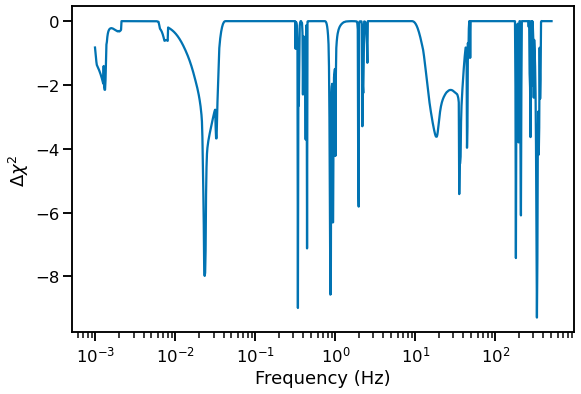

In [9]:
# total_cpds = total_cpds_list[-1]
# QPO_nu, chisq0, chisq, dof = QPO_scan(total_cpds)
print(np.min(chisq-chisq0))
print(chisq0)
print(dof)

plt.figure(figsize=(9,6))
plt.plot(QPO_nu, chisq-chisq0)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\Delta \chi^{2}$')

In [4]:
total_cpds = total_cpds_list[-1]
split_time = [128,256,512,1024][-1]
popt, pcov, chisq0, chisq = model_continuum_noise_pl(total_cpds, plot=True, plot_dir=plot_dir, nu_max = 1.0, \
                                                              plot_name=OBSID + '_' + str(int(split_time)) + 's_chusplit_pl.pdf', f_res = f_res)
print(popt)
print(np.sqrt(np.diag(pcov)))
pl_rms = popt[0]/
# print(np.sqrt(popt[1]/2))

nu_max = 1000
nu_mask = total_cpds.freq<nu_max
rms_square = np.sum(total_cpds.power[nu_mask]*total_cpds.df)
rms_square_err = np.sqrt(np.sum(np.square(total_cpds.power_err[nu_mask])))*total_cpds.df

if rms_square < 0.0:
    uplim = True
    rms = np.sqrt(rms_square + 2.6*rms_square_err)
    print('Upper limit')
else:
    uplim = False
    rms = np.sqrt(rms_square)

rms_err = np.sqrt(np.sum(np.square(total_cpds.power_err[nu_mask])))*total_cpds.df/(2*rms)

print(str(rms) + ' +/- ' + str(rms_err))
print(rms_square)

[8.11280455e-06]
[2.66640058e-07]
Upper limit
0.3637829023860078 +/- 0.2692574192966333
-0.37700847643122903


In [10]:
total_pds = total_pds_list[-1]
split_time = [128,256,512,1024][-1]
popt, pcov, chisq0, chisq = model_continuum_noise_pl(total_pds, plot=True, plot_dir=plot_dir, nu_max = 1.0, \
                                                              plot_name=OBSID + '_' + str(int(split_time)) + 's_chusplit_pl.pdf', f_res = f_res)
print(popt)
print(np.sqrt(np.diag(pcov)))
print(np.sqrt(popt[1]/2))

nu_max = 0.1
nu_mask = total_pds.freq<nu_max
rms_square = np.sum(total_pds.power[nu_mask]*total_pds.df)
rms_square_err = np.sqrt(np.sum(np.square(total_pds.power_err[nu_mask])))*total_pds.df

if rms_square < 0.0:
    uplim = True
    rms = np.sqrt(rms_square + 2.6*rms_square_err)
    print('Upper limit')
else:
    uplim = False
    rms = np.sqrt(rms_square)

rms_err = np.sqrt(np.sum(np.square(total_pds.power_err[nu_mask])))*total_pds.df/(2*rms)

print(str(rms) + ' +/- ' + str(rms_err))
print(rms_square)

0.08544618901353424 +/- 0.02037580137741066
0.007301051216936618
